In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%load_ext autoreload


from pta_replicator import sim as ptrsim
from pta_replicator import spharmORFbasis as ptrspharm
import libstempo.plot as LP, libstempo.toasim as LT

import astropy
from astropy import units as u, constants as c
from pint import pulsar_mjd
from pint import simulation as psim
from astropy.time import Time
from pint import toa
import pint

from enterprise.signals import utils 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import copy

import ephem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from loguru import logger
pint.logging.setup(sink=sys.stderr, level="WARNING", usecolors=True)

1

WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/model_builder.py:198 UserWarning: Unrecognized parfile line 'EPHVER 5'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/model_builder.py:198 UserWarning: Unrecognized parfile line 'EPHVER 5'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging            

In [7]:
# let's grab all of the parfiles from 12p5 dataset and pick out the 4 simulation pulsars

par_dir = '/home/nima/nanograv/bwm_fpfe/12.5yr_blankresids/NANOparfiles/'
psrnames = []
for fname in sorted(os.listdir(par_dir))[0:4]:
    psrnames.append(fname.strip('.par'))
print(psrnames)

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']


In [ ]:
# Make base fakepar/faketim files for these 
# outdir_top = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/'

# for psrname in psrnames:
#     fakepar = par_dir + '{}.par'.format(psrname)
#     fake_obstimes = np.arange(53000, 53000 + 365.25*12, 30)
#     fakepsr = LT.fakepulsar(fakepar, obstimes = fake_obstimes, toaerr=0.2)

#     os.makedirs(outdir_top, exist_ok=True)
#     fakepsr.savepar(outdir_top + 'base_partim/{}_fake.par'.format(fakepsr.name))
#     fakepsr.savetim(outdir_top + 'base_partim/{}_fake.tim'.format(fakepsr.name))


In [ ]:
# ptr_simpsrs = []
# for psrname in psrnames:
#     parfile_path = outdir_top + 'base_partim/{}_fake.par'.format(psrname)
#     timfile_path = outdir_top + 'base_partim/{}_fake.tim'.format(psrname)
    
#     with open(parfile_path, 'r') as pfile:
#         with open(timfile_path, 'r') as tfile:
#             ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
#             ptr_simpsrs.append(ptr_psr)

# Let's try to load in a parfile and make a PINT simulated pulsar

In [ ]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'
for psrname in psrnames:
    parfile = super_partimdir + '{}_fake.par'.format(psrname)
    psr_tm = pint.models.get_model(parfile)
    
    obs_times = np.arange(53000, 53000 + 365.25*12, 30)
    pint_ts = Time(obs_times, scale="utc", format="pulsar_mjd")
    fake_toas = psim.make_fake_toas_fromMJDs(pint_ts, psr_tm, error=(0.2 * u.microsecond))
    outtim = super_partimdir + '{}_fake.tim'.format(psrname)
    fake_toas.write_TOA_file(outtim)

In [12]:
def plot_resids(ptr_psr):
#     toas = np.array(ptr_psr.toas.table['tdbld'], dtype='float64')
#     resids = np.array(ptr_psr.rs.resids, dtype='float64')
#     errors = np.array(ptr_psr.toas.table['error'], dtype='float64')
    
    toas = ptr_psr.toas.table['tdbld']
#     resids = [(q.to('s')).value for q in ptr_psr.rs.resids] # the resids are stored as quantities
    resids = ptr_psr.rs.resids.to('s')
    errors = ptr_psr.toas.table['error'].quantity.to('s')

    
    print(type(resids[0]))
    print(type(toas[0]))
    print(type(errors[0]))
    
    fig, ax = plt.subplots(figsize = (10,10))
    ax.scatter(toas, resids)
    ax.errorbar(toas, resids, yerr=errors, fmt='o')
    ax.set_title("PSR {} residuals".format(ptr_psr.name))
    plt.show()

In [ ]:
ptr_simpsrs = []
for psrname in psrnames:
    parfile_path = super_partimdir + '{}_fake.par'.format(psrname)
    timfile_path = super_partimdir + '{}_fake.tim'.format(psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
            ptr_simpsrs.append(ptr_psr)

In [ ]:
ptr_simpsrs[0].fit()
plot_resids(ptr_simpsrs[0])

In [ ]:
ploc = ptr_simpsrs[0].loc
if "RAJ" and "DECJ" in ploc.keys():
    ptheta = np.pi / 2 - ploc["DECJ"]
    pphi = ploc["RAJ"]
elif "ELONG" and "ELAT" in ploc.keys():
    fac = 1.0
    if "B" in ptr_simpsrs[0].name:
        epoch = "1950"
    else:
        epoch = "2000"
    coords = ephem.Equatorial(ephem.Ecliptic(str(ploc["ELONG"] * fac), str(ploc["ELAT"] * fac)), epoch=epoch)

    ptheta = np.pi / 2 - float(repr(coords.dec))
    pphi = float(repr(coords.ra))
    
bwm_phi = pphi + 0.03
bwm_theta = ptheta - 0.02
bwm_pol = -np.pi/8

In [ ]:
ptrsim.add_gw_memory(ptr_simpsrs[0], 1e-14, bwm_theta, bwm_phi, bwm_pol, 54000)
ptr_simpsrs[0].fit()

In [ ]:
plot_resids(ptr_simpsrs[0])

In [ ]:
print(ptr_simpsrs[0].toas.get_summary())

In [ ]:
ptrsim.add_efac(ptr_simpsrs[0],1)
ptr_simpsrs[0].fit()
plot_resids(ptr_simpsrs[0])

# Great! Let's make a full data set now using PTR SIM

In [11]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/'
os.makedirs(super_partimdir, exist_ok=True)

base_pardir = "/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/"
nrealization = 1000
for realization in range(nrealization):
    realization_dir = super_partimdir + '{}/'.format(realization)
    os.makedirs(realization_dir, exist_ok=True)

    for psrname in psrnames:
        parfile_path = base_pardir + '{}_fake.par'.format(psrname)
        timfile_path = base_pardir + '{}_fake.tim'.format(psrname)
          
        with open(parfile_path, 'r') as pfile:
            with open(timfile_path, 'r') as tfile:
                ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

        ptr_psr.fit()
        ptrsim.add_efac(ptr_psr, 1)
        ptr_psr.fit()
        ptr_psr.write_partim(outpar = realization_dir + '{}.par'.format(psrname, realization), outtim = realization_dir + '{}.tim'.format(psrname, realization))
        
        
        

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


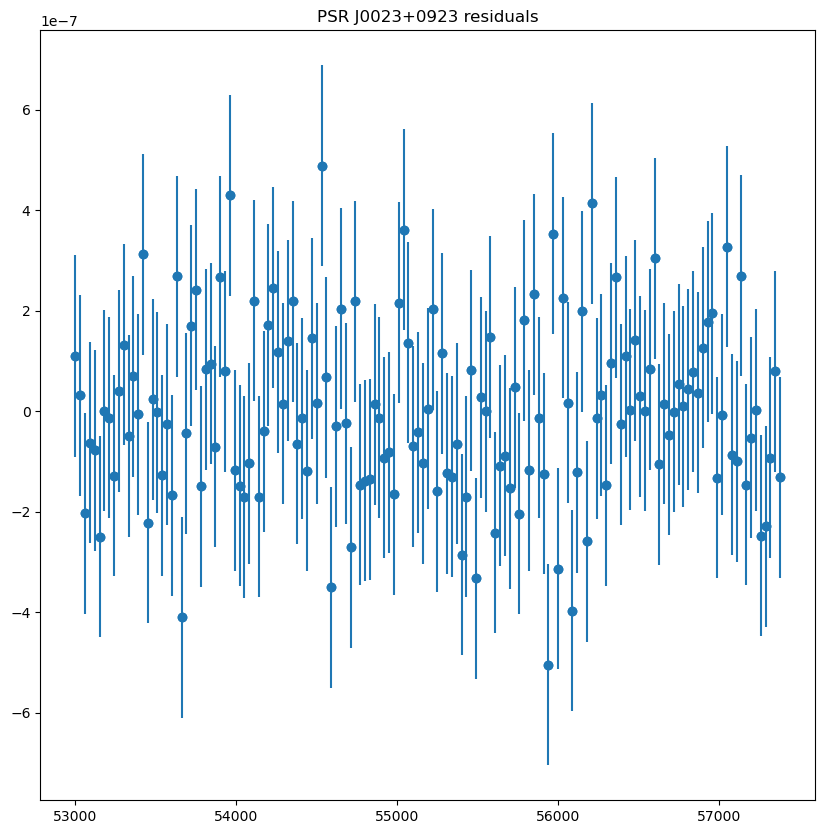

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


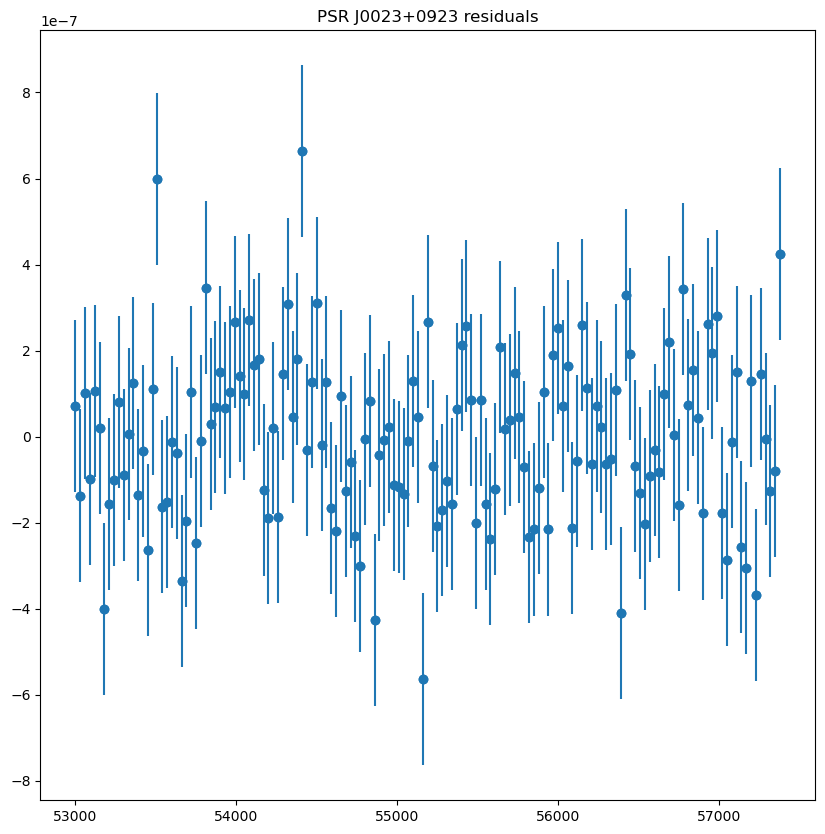

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


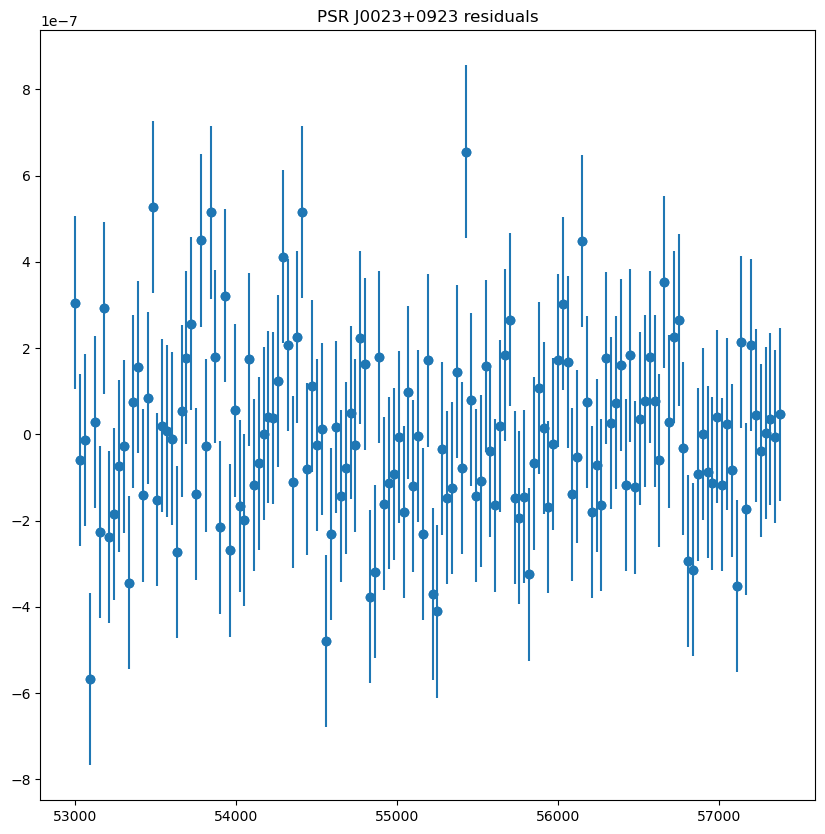

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


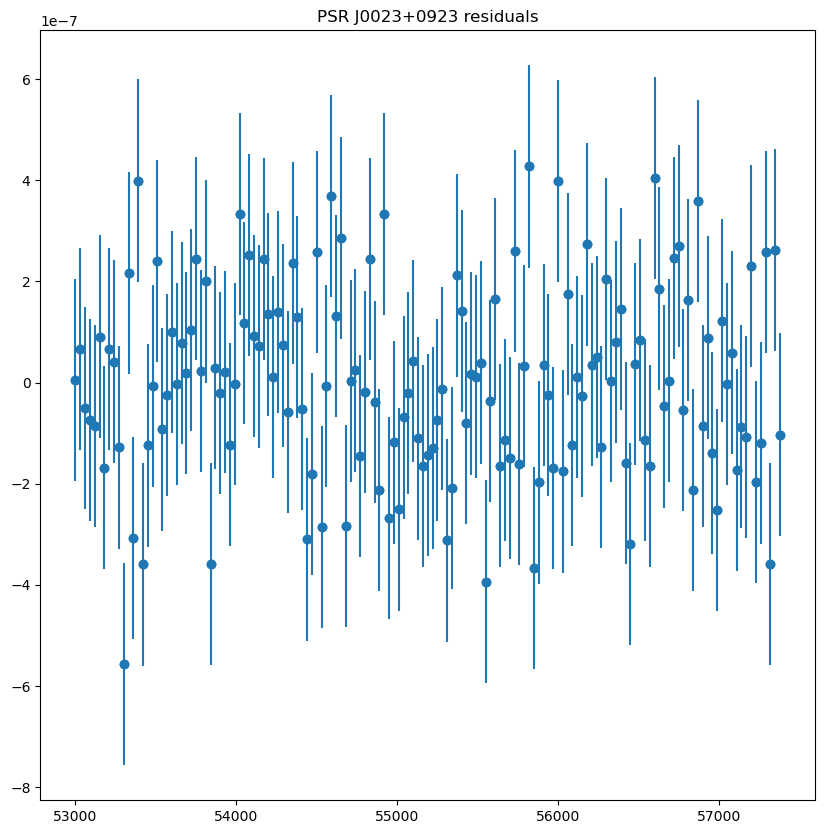

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


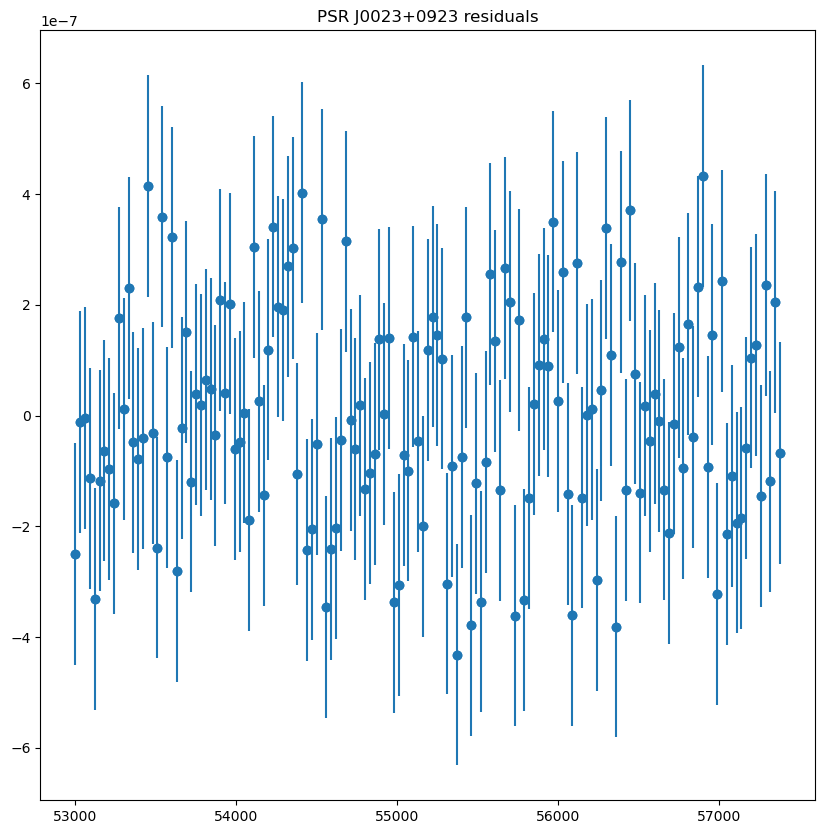

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


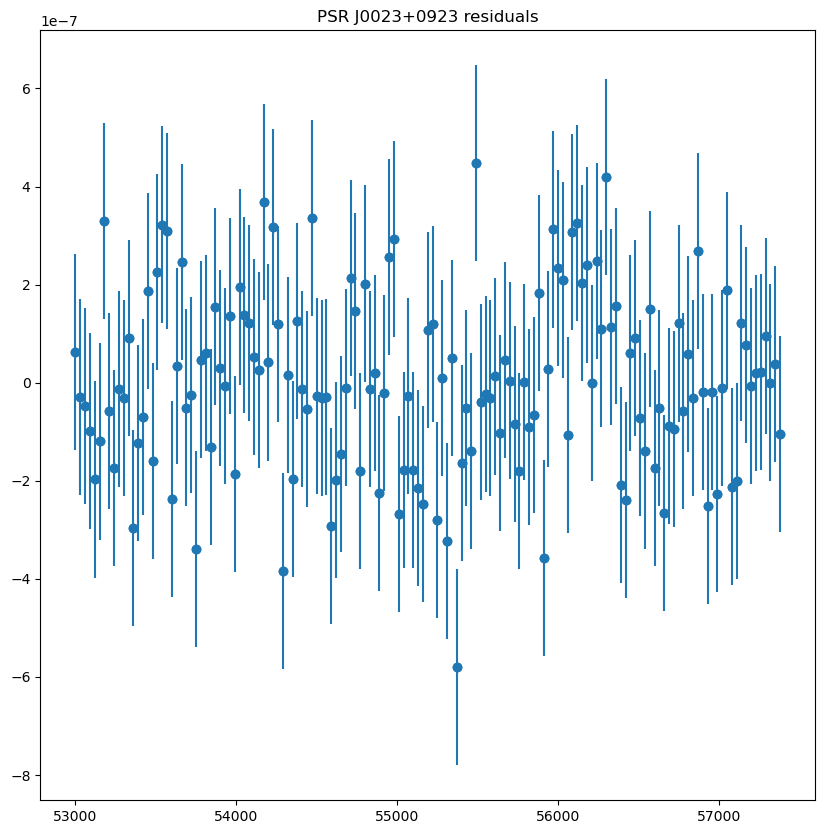

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


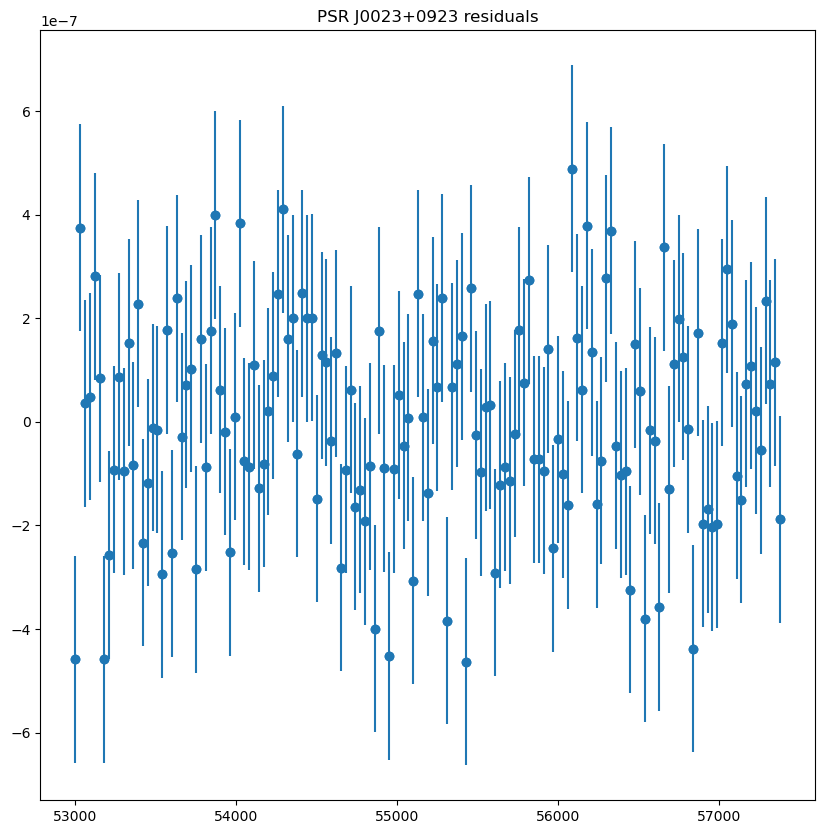

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


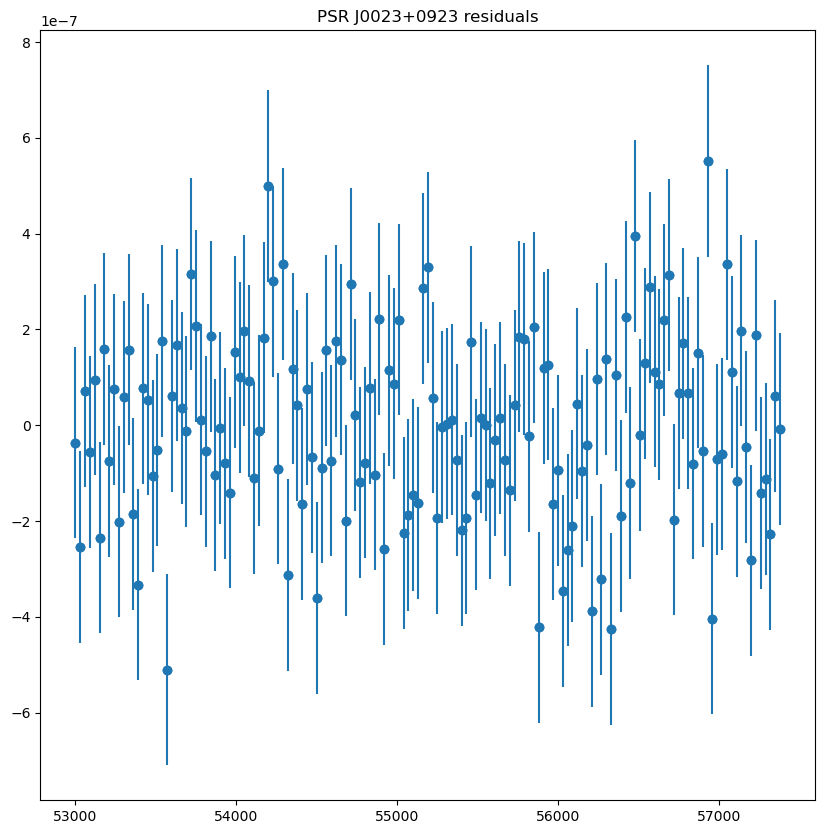

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


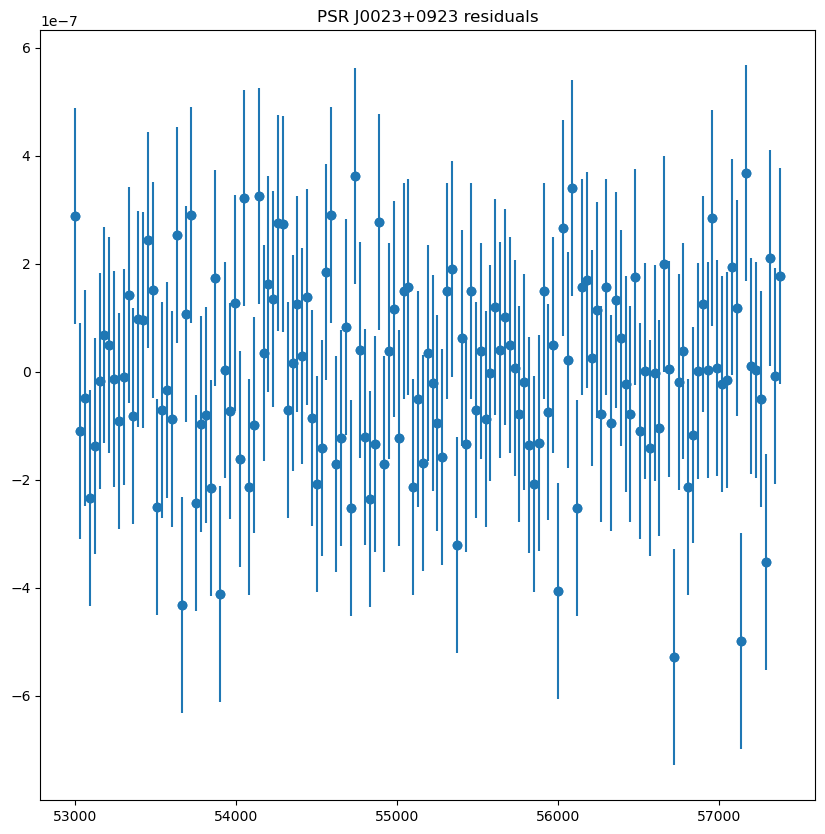

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


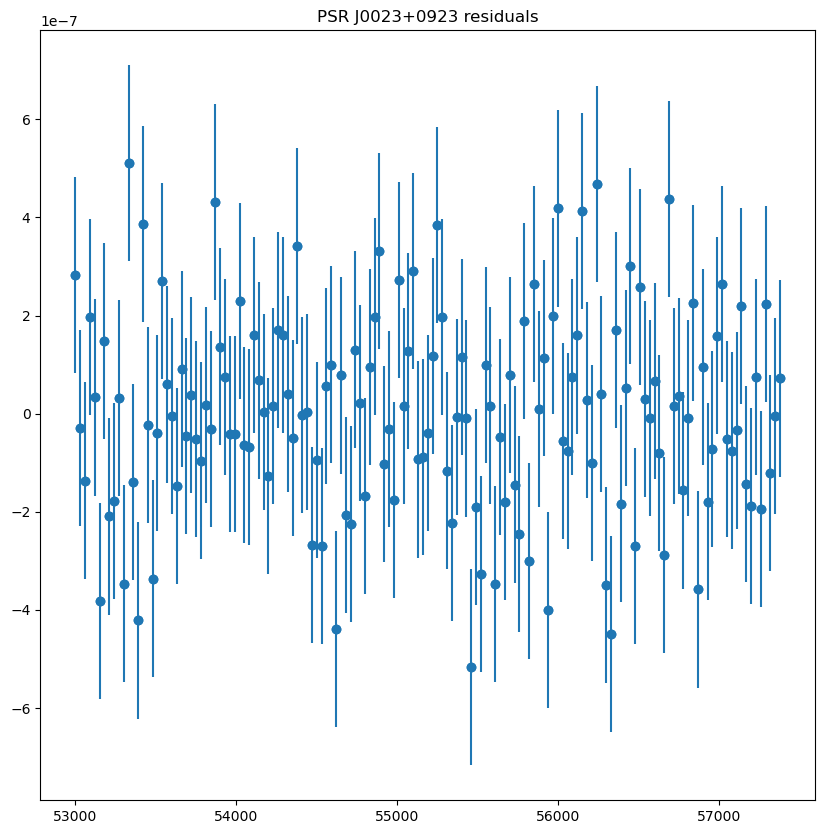

In [14]:
for i in range(10):
    parfile_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/{}/{}.par'.format(i,psrname)
    timfile_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/{}/{}.tim'.format(i,psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

    plot_resids(ptr_psr)

# Scratch

In [ ]:
test1855 = ptr_simpsrs[0]
ts = test1855.toas

In [ ]:
type(ts.table['error'].quantity)
print(ts.table['error'].quantity.to('s'))

In [ ]:
test1855.rs.resids.to('s')